<a href="https://colab.research.google.com/github/jmk9/PyTorch_seminar/blob/master/Autoencoder/PyTorch_modify_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from torch.autograd import Variable

In [0]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [0]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [0]:
images.shape

torch.Size([64, 1, 28, 28])

In [0]:
labels.shape

torch.Size([64])

# Linear autoencoder model

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        # print('Before encoder: ', x.shape)
        encoded = self.encoder(x)
        # print('After encoder: ', x.shape)
        decoded = self.decoder(encoded)
        # print('After decoder: ', x.shape)
        return encoded, decoded

# CNN autoencoder model

In [0]:
class Conv_autoencoder(nn.Module):
    def __init__(self):
        super(Conv_autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(64, 128, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            

            nn.Conv2d(128, 64, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64,32, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16,3, kernel_size= 3, padding=1), # 입력의 특징을 3차원으로 압축합니다
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 28*28, kernel_size=3, padding=1),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        # print('Before encoder: ', x.shape)
        encoded = self.encoder(x)
        # print('After encoder: ', x.shape)
        decoded = self.decoder(encoded)
        # print('After decoder: ', x.shape)
        return encoded, decoded

# Set dataset

In [0]:
autoencoder = Autoencoder().to(DEVICE)
conv_autoencoder = Conv_autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
conv_optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:
train_data = trainset.data[:5]

In [0]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = train_data.view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [0]:
con_data = train_data.unsqueeze(1)[:5]
con_data = con_data.type(torch.FloatTensor)/255.
# con_data = train_data.view(-1, 28*28)[:5]
# con_data = con_data.type(torch.FloatTensor)/255.

In [0]:
print(train_data.shape)
print(view_data.shape)
print(con_data.shape)

torch.Size([5, 28, 28])
torch.Size([5, 784])
torch.Size([5, 1, 28, 28])


# Create training def

In [0]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
    #     x = x.to(DEVICE)
    #     y = x.to(DEVICE)
        label = label.to(DEVICE)
        # print('x.shape :', x.shape)
        # print('y.shape :', y.shape)
        # print('label :', label)

        encoded, decoded = autoencoder(x)

        # print('encoded :', encoded.shape)
        # print('decoded :', decoded.shape)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print('+' * 20)

        # if step == 5:
        #   break


In [0]:
def conv_train(autoencoder, train_loader):
    conv_autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.to(DEVICE)
        y = x.to(DEVICE)
        # print('x.shape :', x.shape)
        # print('y.shape :', y.shape)
        label = label.to(DEVICE)

        encoded, decoded = conv_autoencoder(x)

        # print('encoded :', encoded.shape)
        # print('decoded :', decoded.shape)

        loss = criterion(decoded, y)
        conv_optimizer.zero_grad()
        loss.backward()
        conv_optimizer.step()
        # print('+' * 20)


# Linear autoencoder training

In [0]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    #원본과 디코딩 결과 비교해보기

    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

    print('+' * 30)

KeyboardInterrupt: ignored

# CNN autoencoder training

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 784, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 784, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1]


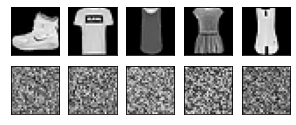

[Epoch 2]


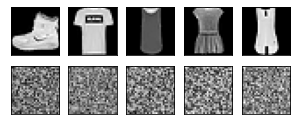

[Epoch 3]


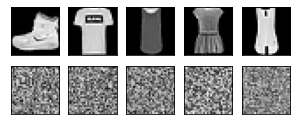

[Epoch 4]


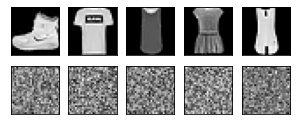

[Epoch 5]


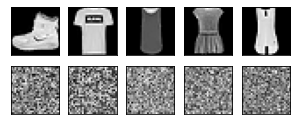

[Epoch 6]


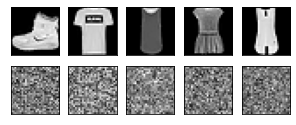

[Epoch 7]


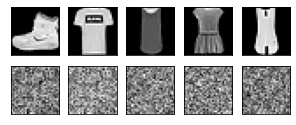

[Epoch 8]


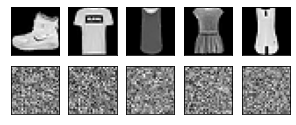

[Epoch 9]


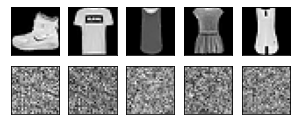

[Epoch 10]


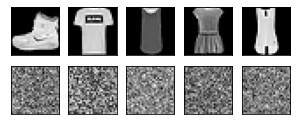

In [0]:
for epoch in range(1, EPOCH+1):
    conv_train(conv_autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = con_data.to(DEVICE)
    _, decoded_data = conv_autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(con_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()